### Мастерская 2 
***Описание:*** 

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

***Цель:***

Предсказать вероятность покупки в течение 90 дней

***Задачи:***
 - Изучить данные
 - Разработать полезные признаки
 - Создать модель для классификации пользователей
 - Улучшить модель и максимизировать метрику roc_auc
 - Выполнить тестирование

***Данные:***

**'apparel-purchases'**
история покупок
 - client_id идентификатор пользователя
 - quantity количество товаров в заказе
 - price цена товара
 - category_ids вложенные категории, к которым отнсится товар
 - date дата покупки
 - message_id идентификатор сообщения из рассылки

**'apparel-messages'**
история рекламных рассылок
 - bulk_campaign_id идентификатор рекламной кампании
 - client_id идентификатор пользователя
 - message_id идентификатор сообщений
 - event тип действия
 - channel канал рассылки
 - date дата рассылки
 - created_at точное время создания сообщения

**'apparel-target_binary'**
совершит ли клиент покупку в течение следующих 90 дней
 - client_id идентификатор пользователя
 - target целевой признак

***Результат***
Репозиторий на гитхабе:
 - тетрадь jupyter notebook с описанием, подготовкой признаков, обучением модели и
тестированием
 - описание проекта и инструкция по использованию в файле README.md
 - список зависимостей в файле requirements.txt

 ***Этапы исследования***
- **Этап 1.** Загрузка, обзор и изучение данных
- **Этап 2.** Предобработка данных: проверка на пропуски, поиск аномалий,при необходимости переименовка и приведение к единому стилю данных
- **Этап 3.** Исследовательский анализ данных: изучение и построение графиков для признаков, выводы на основе этих графиков
- **Этап 4.** Добавление новых признаков
- **Этап 5.** Корреляционный анализ данных: изучение зависимостей признаков
- **Этап 6.** Подготовка и настройка Pipeline. 
- **Этап 7.** Построение модели машинного обучения. 
- **Этап 8.** Построение Shap, анализ важности признаков. 
- **Этап 9.** Общий вывод.


In [231]:
#установим библиотеки для работы
# !pip install phik -q
# !pip install shap -q
# !pip install scikit-learn -q
# !pip install matplotlib -q
# !pip install catboost -q
# !pip install xgboost -q
# !pip install lightgbm -q
# !pip install optuna -q
# !pip install optuna-integration[sklearn] -q 

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import sklearn
from phik import phik_matrix
import shap
import ast



In [233]:
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder,
    FunctionTransformer)
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.compose import ColumnTransformer


# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


# импортируем класс GridSearchCV
from sklearn.model_selection import GridSearchCV

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные классы
from sklearn.pipeline import Pipeline

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

RANDOM_STATE = 42
TEST_SIZE = 0.25

### 1. Загрузка, обзор и изучение данных

In [234]:
try:
    df_purchases = pd.read_csv('C:/Users/zurik/YandexDisk/Yandex Practicum/Data Science/Masterskaya_2/filtered_data/apparel-purchases.csv')
except:
    df_purchases = pd.read_csv('D:/YandexDisk/Yandex Practicum/Data Science/Masterskaya_2/filtered_data/apparel-purchases.csv')


df_purchases.info()
df_purchases.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


,client_id,quantity,price,category_ids,date,message_id
185630,1515915625500249647,1,745.0,"['5562', '5589', '5610', '1636']",2023-12-23,1515915625489898786-14352-658557b643efa
101172,1515915625489738234,1,1698.0,"['2', '18', '258', '441']",2023-04-12,1515915625489738234-11760-64367406cfdd3
182872,1515915625490776548,1,261.0,"['5562', '5632', '5577', '1338']",2023-12-19,1515915625490776548-14330-65806b8eedf4e
143466,1515915625487963453,1,360.0,"['5562', '5634', '5693', '636']",2023-06-22,1515915625487963453-13384-64940464d9da7
96158,1515915625468159433,1,199.0,"['4', '28', '228', '435']",2023-03-29,1515915625468159433-11208-6423f16862dc1


In [235]:
try:
    df_messages = pd.read_csv('C:/Users/zurik/YandexDisk/Yandex Practicum/Data Science/Masterskaya_2/filtered_data/apparel-messages.csv')
except:
    df_messages = pd.read_csv('D:/YandexDisk/Yandex Practicum/Data Science/Masterskaya_2/filtered_data/apparel-messages.csv')



df_messages.info()
df_messages.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
8255457,13908,1515915625949637700,1515915625949637700-13908-651e79e6b38e4,send,email,2023-10-05,2023-10-05 10:25:27
1750927,6859,1515915625743257194,1515915625743257194-6859-6336e86e3be0f,send,mobile_push,2022-09-30,2022-09-30 13:47:11
4576879,11208,1515915625802095977,1515915625802095977-11208-6423f14454fd1,send,email,2023-03-29,2023-03-29 09:48:46
8291014,13913,1515915625569309666,1515915625569309666-13913-651fa2d031764,open,mobile_push,2023-10-06,2023-10-06 06:38:38
4641033,11491,1515915625468177444,1515915625468177444-11491-642bd7444ff95,open,email,2023-04-04,2023-04-04 08:16:08


In [236]:
print(df_messages.isnull().sum())  # посмотрим NaN значений в каждом столбце
print(df_messages.notnull().sum()) # посмотрим количество ненулевых значений в каждом столбце

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64
bulk_campaign_id    12739798
client_id           12739798
message_id          12739798
event               12739798
channel             12739798
date                12739798
created_at          12739798
dtype: int64


In [237]:
try:
    df_target = pd.read_csv('C:/Users/zurik/YandexDisk/Yandex Practicum/Data Science/Masterskaya_2/filtered_data/apparel-target_binary.csv')
except:
    df_target = pd.read_csv('D:/YandexDisk/Yandex Practicum/Data Science/Masterskaya_2/filtered_data/apparel-target_binary.csv')

df_target.info()
df_target.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


,client_id,target
30904,1515915625576459945,1
48350,1515915625980867545,0
13907,1515915625490475136,0
21959,1515915625514421155,0
8382,1515915625488514287,0


In [238]:
#Соберем данные о признаках, тип, кол-во уникальных значений, значения
attFeatures = []
for i in df_purchases.columns:
  attFeatures.append([i,df_purchases[i].dtype, df_purchases[i].nunique(), df_purchases[i].sort_values().drop_duplicates().values])
pd.DataFrame(attFeatures, columns = ['Features','Type', 'Unique Number', 'Values'])

,Features,Type,Unique Number,Values
0,client_id,int64,49849,"[1515915625468060902, 1515915625468061003, 151..."
1,quantity,int64,16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 18, 20..."
2,price,float64,3642,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ..."
3,category_ids,object,933,"[['1', '22', '50', '685'], ['1', '8', '280', '..."
4,date,object,642,"[2022-05-16, 2022-05-17, 2022-05-18, 2022-05-1..."
5,message_id,object,50204,"[1515915625468060902-4617-6290657dac196, 15159..."


In [239]:
df_purchases.describe()

,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459514e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000


In [240]:
df_purchases.describe(include=['object'])

,category_ids,date,message_id
count,202208,202208,202208
unique,933,642,50204
top,"['4', '28', '57', '431']",2022-11-11,1515915625489095763-6251-6311b13a4cf78
freq,8626,5270,365


In [241]:
#Соберем данные о признаках, тип, кол-во уникальных значений, значения
attFeatures2 = []
for i in df_messages.columns:
  attFeatures2.append([i,df_messages[i].dtype, df_messages[i].nunique(), df_messages[i].sort_values().drop_duplicates().values])
pd.DataFrame(attFeatures2, columns = ['Features','Type', 'Unique Number', 'Values'])

,Features,Type,Unique Number,Values
0,bulk_campaign_id,int64,2709,"[548, 563, 585, 594, 602, 634, 657, 676, 693, ..."
1,client_id,int64,53329,"[1515915625468060902, 1515915625468061003, 151..."
2,message_id,object,9061667,"[1515915625468060902-10022-63e5ededd911f, 1515..."
3,event,object,11,"[click, close, complain, hard_bounce, hbq_spam..."
4,channel,object,2,"[email, mobile_push]"
5,date,object,638,"[2022-05-19, 2022-05-20, 2022-05-21, 2022-05-2..."
6,created_at,object,4103539,"[2022-05-19 00:14:20, 2022-05-19 00:39:34, 202..."


In [242]:
df_messages.describe()

,bulk_campaign_id,client_id
count,1.273980e+07,1.273980e+07
mean,1.160459e+04,1.515916e+18
std,3.259211e+03,3.265518e+08
min,5.480000e+02,1.515916e+18
25%,8.746000e+03,1.515916e+18
50%,1.351600e+04,1.515916e+18
75%,1.415800e+04,1.515916e+18
max,1.465700e+04,1.515916e+18


In [243]:
df_messages.describe(include=['object'])

,message_id,event,channel,date,created_at
count,12739798,12739798,12739798,12739798,12739798
unique,9061667,11,2,638,4103539
top,1515915625489095763-6251-6311b13a4cf78,send,mobile_push,2023-06-10,2023-12-29 15:20:53
freq,1454,9058196,7512156,89661,621


**Выводы:**
- Данные соответствуйют правильным типам, кроме колонок с датами, регистр корректный
- Пропуски не обнаружены
- Датафрейм с покупками имеет 0,2 млн строчек, а датафрейм с рассылками 12 млн
- Уникальный пользоваталей в df_purchases и в df_target - 49849. а в df_messages - 53329

### 2. Предобработка данных

In [244]:
# Проверим данные на явные дубликаты 

print('Количество дубликатов в df_purchases:', df_purchases.duplicated().sum())
print('Количество дубликатов в df_messages:', df_messages.duplicated().sum())

Количество дубликатов в df_purchases: 73020
Количество дубликатов в df_messages: 48610


In [245]:
# Посмотрим на дубликаты
df_purchases[df_purchases.duplicated(keep=False)].head(10)


,client_id,quantity,price,category_ids,date,message_id
11,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
21,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
22,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
41,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
42,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
58,1515915625468126078,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
59,1515915625468126078,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
61,1515915625468141317,1,49.0,"['4', '27', '38', '481']",2022-05-17,1515915625468141317-4439-6283412e01078
62,1515915625468141317,1,49.0,"['4', '27', '38', '481']",2022-05-17,1515915625468141317-4439-6283412e01078


Дубликаты в df_purchases не будем удалять т.к. не полной уверенности в дубликатах т.к. один и тот же клиент может покупать одинаковый товар несколько раз в день, а точного время покупок нет 

In [246]:
# Удалим дубликаты df_messages

df_messages = df_messages.drop_duplicates()

In [247]:
# переведем столбы с датами в datetime формат

df_purchases['date'] = pd.to_datetime(df_purchases['date'])
df_messages['date'] = pd.to_datetime(df_messages['date'])
df_messages['created_at'] = pd.to_datetime(df_messages['created_at'])

In [248]:
df_messages.info()
print(df_messages.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 774.6+ MB
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64


 - Удалили явные дубликаты из df_messages.
 - Пропуски не обнаружены
 - Преобразовали столбцы с датами в datetime формат


### Исследовательский анализ данных

#### df_purchases изучение

In [249]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [250]:
# Напишем функцию для построения гистограммы и бокслпота количественных признаков
def plot_overlay_histograms(df, numeric_columns):
    for column in numeric_columns:
        plt.figure(figsize=(12, 4)) # Увеличиваем ширину фигуры для горизонтального расположения

        # Гистограмма
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], bins=30, color='blue', alpha=0.5, kde=True)
        plt.title(f'Гистограмма распределения для {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')

        # Боксплот
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[column], color='lightgreen')
        plt.title(f'Боксплот для {column}')
        plt.xlabel(column)

        plt.tight_layout()
        plt.show()

        # Вывод статистического описания для df
        print(f"Статистическое описание для {column}")
        print(df[column].describe())
        print("\n")



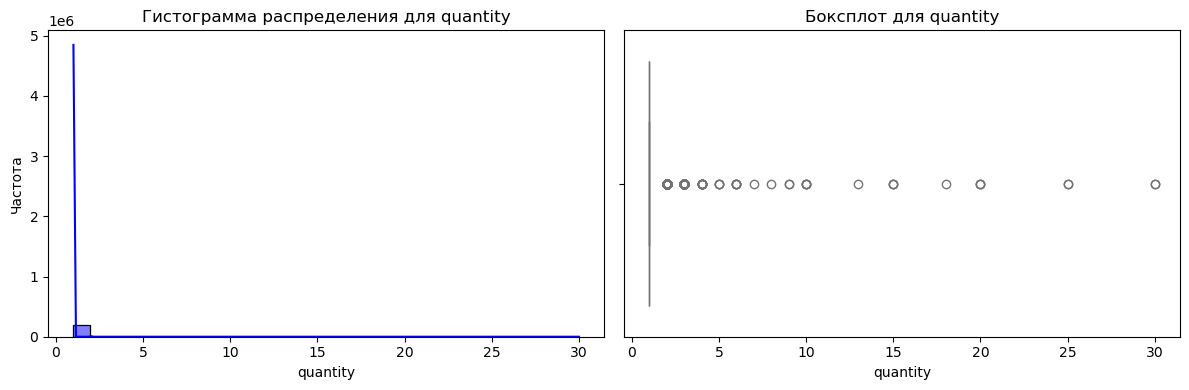

Статистическое описание для quantity
count    202208.000000
mean          1.006483
std           0.184384
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64




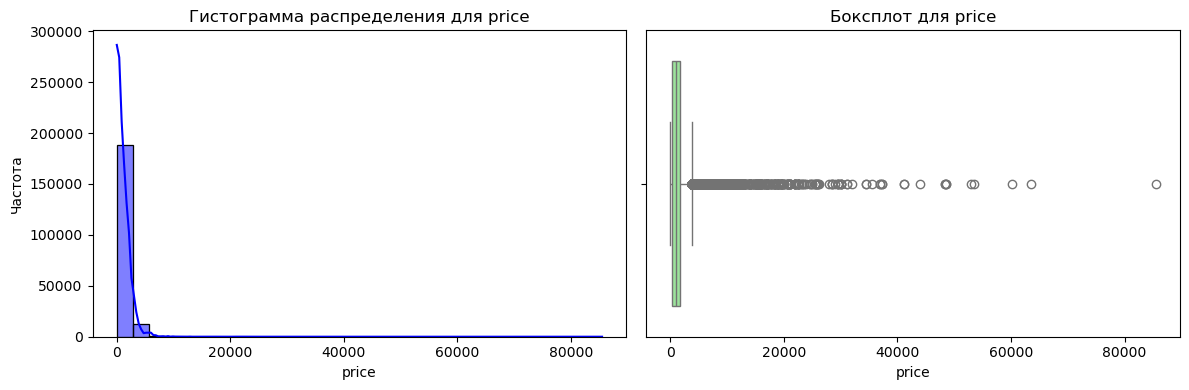

Статистическое описание для price
count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
max       85499.000000
Name: price, dtype: float64




In [251]:
numerical_columns = ['quantity', 'price']


plot_overlay_histograms(df_purchases, numerical_columns)

In [252]:
df_purchases[df_purchases['quantity'] == 30]

,client_id,quantity,price,category_ids,date,message_id
37005,1515915625548883766,30,2.0,"['5562', '5597', '5691', '889']",2022-09-06,1515915625548883766-6283-6316e248bbbf9
158373,1515915625594593699,30,2.0,"['5562', '5597', '5691', '889']",2023-07-12,1515915625468268596-13482-64ae724c9316b


In [253]:
print(df_purchases[df_purchases['price'] == 85499])
df_purchases[df_purchases['price'] <= 1]

                  client_id  quantity    price                category_ids  \
186736  1515915625553309277         1  85499.0  ['4', '29', '313', '1574']   

             date                               message_id  
186736 2023-12-24  1515915625553309277-14352-6585585d7a711  


,client_id,quantity,price,category_ids,date,message_id
22153,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
22154,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
32063,1515915625490679651,1,1.0,"['4', '28', '44', '1594']",2022-08-19,1515915625490679651-5922-62ff354e68cd3
32064,1515915625490679651,1,1.0,"['4', '28', '44', '1594']",2022-08-19,1515915625490679651-5922-62ff354e68cd3
32283,1515915625578652401,1,1.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f
...,...,...,...,...,...,...
198702,1515915625615134152,1,1.0,"['2', '18', '61', '660']",2024-02-02,1515915625615134152-14590-65bcac271717b
199509,1515915625505063729,1,1.0,[],2024-02-08,1515915625505063729-14582-65bb5a2b9adcc
199510,1515915625505063729,1,1.0,[],2024-02-08,1515915625505063729-14582-65bb5a2b9adcc
201246,1515915625558967191,1,1.0,[],2024-02-14,1515915625980158750-14649-65cca1c3cc334


 - Большинство покупок с количеством 1 шт. Возможно марктеплейс именно так учитывает покупки и не склеивает их. Есть покупки с кол-во 30 шт, что допустимо
 - Средняя цена покупки 987 руб. Но есть покупки за 1 руб, и есть покупка за 85499 руб. Мы доаускаем, что могут быть акции по 1 руб или дорогой товар за 86 тыс. Или учетная цена вообще не рубль, а другая валюта, поэтому не будем удалять
 - 

In [254]:
# Посмотрим на распределение дат
def plot_date_distributions(df, date_columns):
    for column in date_columns:
        plt.figure(figsize=(7, 4))

        # Гистограмма распределения дат
        sns.histplot(df[column], bins=30, kde=True, color='blue')
        plt.title(f'Распределение дат для {column}')
        plt.xlabel('Дата')
        plt.ylabel('Частота')

        plt.xticks(rotation=45) # Поворот меток на оси X для лучшей читаемости
        plt.tight_layout()
        plt.show()

    # Вывод статистического описания для df
        print(f"Статистическое описание для {column}")
        print(df[column].describe())
        print("\n")



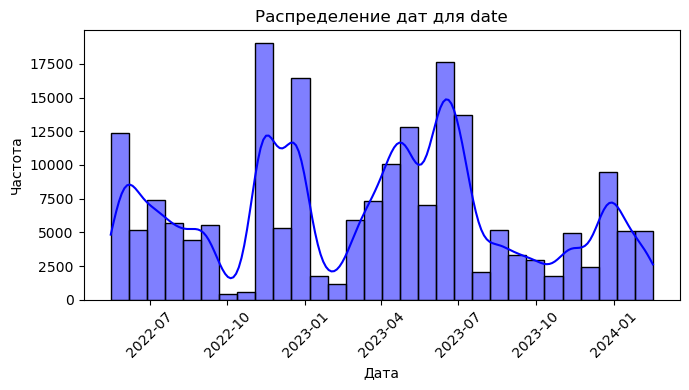

Статистическое описание для date
count                           202208
mean     2023-03-17 02:49:35.739832064
min                2022-05-16 00:00:00
25%                2022-11-12 00:00:00
50%                2023-04-12 00:00:00
75%                2023-07-03 00:00:00
max                2024-02-16 00:00:00
Name: date, dtype: object




In [255]:
date_columns =['date'] 
plot_date_distributions(df_purchases, date_columns)

Датасет содержит данные примерно за 2 года, начиная с мая 2022. Данные распределены равномерно, видим очевидные спады в продажах в октябре 2022, январе 23. 

In [256]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


Исследуем 'category_ids'

In [257]:
df_purchases['category_ids'].value_counts()

category_ids
['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
['4', '28', '244', '432']           6821
[]                                  5579
['4', '28', '275', '421']           4936
                                    ... 
['4', '5837', '5836', '839']           1
['5562', '5632', '5552', '1089']       1
['4', '27', '278', '471']              1
['5562', '5697', '5651', '1153']       1
['5562', '5597', '5696', '5529']       1
Name: count, Length: 933, dtype: int64

In [258]:
# Преобразование строк в списки с проверкой
def convert_to_list(s):
    try:
        return ast.literal_eval(s)
    except (ValueError, SyntaxError):
        return []

df_purchases['category_ids'] = df_purchases['category_ids'].apply(convert_to_list)

# Извлечение элементов из списка с проверкой на наличие
df_purchases['category_1'] = df_purchases['category_ids'].apply(lambda x: x[0] if x and len(x) > 0 else None)
df_purchases['category_2'] = df_purchases['category_ids'].apply(lambda x: x[1] if x and len(x) > 1 else None)
df_purchases['category_3'] = df_purchases['category_ids'].apply(lambda x: x[2] if x and len(x) > 2 else None)
df_purchases['category_4'] = df_purchases['category_ids'].apply(lambda x: x[3] if x and len(x) > 3 else None)


In [259]:
df_purchases.sample(5)

,client_id,quantity,price,category_ids,date,message_id,category_1,category_2,category_3,category_4
131142,1515915625822967540,1,3383.0,"[4, 28, 275, 673]",2023-06-09,1515915625822967540-13157-648319c89df71,4,28,275,673
97664,1515915625492584050,1,2099.0,"[2, 18, 61, 660]",2023-03-30,1515915625492584050-11208-6423f1465c5e7,2,18,61,660
150451,1515915625766049107,1,834.0,"[4, 28, 213, 417]",2023-06-30,1515915625766049107-13392-649554cda2a5a,4,28,213,417
169309,1515915625987378747,1,2599.0,"[4, 29, 312, 934]",2023-09-14,1515915625987378747-13771-64fa9cc007e45,4,29,312,934
173444,1515915625502538873,1,4101.0,"[4, 28, 58, 434]",2023-10-11,1515915625502538873-13933-65250ebdeecc0,4,28,58,434


In [260]:
df_purchases['category_1'].unique()

array(['4', '2', '5562', '1', None, '5963', '3', '6060', '5'],
      dtype=object)

Проверим уникальные значения вложенных категорий второго и третьего уровня

In [261]:
for category in df_purchases['category_1'].unique():
        # Получение уникальных значений из 'category_2' для текущего 'category_1'
        unique_category_2 = df_purchases[df_purchases['category_1'] == category]['category_2'].unique()
        print(f"Уникальные значения для category_1 = {category}: {unique_category_2}")

Уникальные значения для category_1 = 4: ['28' '27' '31' '1822' '5837' '29' '30' '44']
Уникальные значения для category_1 = 2: ['18' '17']
Уникальные значения для category_1 = 5562: ['5631' '5630' '5589' '5634' '5683' '5536' '5597' '5633' '5599' '5632'
 '5558' '5697']
Уникальные значения для category_1 = 1: ['8' '22']
Уникальные значения для category_1 = None: []
Уникальные значения для category_1 = 5963: ['5959']
Уникальные значения для category_1 = 3: ['14' '12']
Уникальные значения для category_1 = 6060: ['6058' '6059' '6057']
Уникальные значения для category_1 = 5: ['10']


In [262]:
for category in df_purchases['category_1'].unique():
        # Получение уникальных значений из 'category_3' для текущего 'category_1'
        unique_category_3 = df_purchases[df_purchases['category_1'] == category]['category_3'].unique()
        print(f"Уникальные значения для category_1 = {category}: {unique_category_3}")

Уникальные значения для category_1 = 4: ['57' '244' '49' '350' '44' '213' '353' '343' '326' '260' '290' '142'
 '275' '340' '156' '181' '287' '324' '249' '38' '146' '1827' '124' '84'
 '233' '278' '5838' '58' '202' '312' '239' '218' '176' '5836' '329' '313'
 '62' '1821' '311' '228' '1824' '310' '1828' '328' '304' '138' '108' '172'
 '315' '309' '254' '104' '63' '186' '339' '327' '1823' '314' '5985' '6013'
 '205' '5984' '428' '1594' '336' '989' '489' '430' '501' '491' '1097'
 '490' '493' '1571' '549' '499' '503' '347' '1564' '492' '528' '1381'
 '494' '6265' '282' '1600' '6309']
Уникальные значения для category_1 = 2: ['258' '341' '123' '267' '344' '212' '173' '180' '155' '243' '274' '171'
 '232' '137' '61' '330' '198' '217' '1826' '279' '83' '107' '188' '248'
 '286' '293']
Уникальные значения для category_1 = 5562: ['5549' '5649' '5584' '5699' '5579' '5568' '5693' '5622' '5575' '5665'
 '5608' '5607' '5626' '5537' '5614' '5677' '5667' '5592' '5612' '5692'
 '5550' '5714' '5581' '5648' '5553'

Мы видим, что значения уникальные, есть некоторые повторы для категорий 3-го уровня, они иногда повторяются в некоторых категориях 1-го. но в любом случае оставляем их, ткт большинство уникально

In [263]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
 6   category_1    195365 non-null  object        
 7   category_2    195365 non-null  object        
 8   category_3    195365 non-null  object        
 9   category_4    194009 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 15.4+ MB


Обработали 'df_purchases':
  - из category_ids вывели 4 новые категории
  - заменили пропуски в них на 0
  - добавили столбцы с годом покупки year_purchase и месяцем покупки month_purchase

#### df_messages изучение

In [264]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 774.6+ MB


In [265]:
df_messages.sample(5)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
9981110,14249,1515915625559093035,1515915625559093035-14249-65704d337ef74,open,mobile_push,2023-12-06,2023-12-06 12:25:26
2272515,7623,1515915625491165291,1515915625491165291-7623-6363c5e9c3227,send,mobile_push,2022-11-03,2022-11-03 13:48:32
11160440,14423,1515915625472113020,1515915625472113020-14423-65952bea770c4,open,mobile_push,2024-01-03,2024-01-03 09:50:47
3286268,8932,1515915625491268219,1515915625491268219-8932-63a4171fbeb96,send,email,2022-12-22,2022-12-22 09:17:36
9777372,14212,1515915625487145515,1515915625487145515-14212-6567126f4bac7,send,mobile_push,2023-11-29,2023-11-29 12:42:48


In [266]:
df_messages['bulk_campaign_id'].value_counts()

bulk_campaign_id
14272    104060
14276     63362
4679      50621
11760     45745
14081     44067
          ...  
657           1
1391          1
1080          1
548           1
4478          1
Name: count, Length: 2709, dtype: int64

In [267]:
# messages_num_columns = ['bulk_campaign_id']


# plot_overlay_histograms(df_messages, messages_num_columns)

In [268]:
# Создадим функцию распределения категориальных данных
def plot_overlay_bar_charts(df, categorical_columns):
    for column in categorical_columns:
        plt.figure(figsize=(7, 3))

        # Построение столбчатой диаграммы
        sns.countplot(data=df, x=column, hue=column, palette='viridis')
        plt.title(f'Распределение категориальных данных для {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')

        plt.xticks(rotation=45) # Поворот меток на оси X для лучшей читаемости
        plt.tight_layout()
        plt.show()

          # Вывод статистического описания для df
        print(f"Статистическое описание для {column}")
        print(df[column].value_counts())
        print("\n")

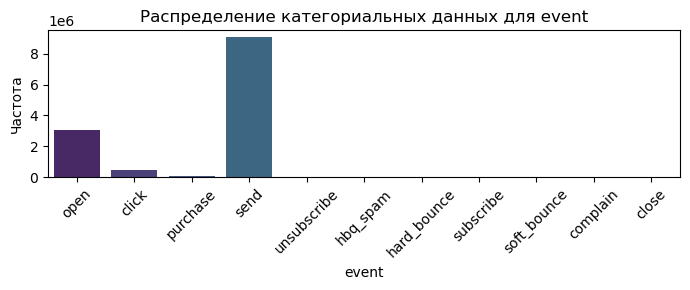

Статистическое описание для event
event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64




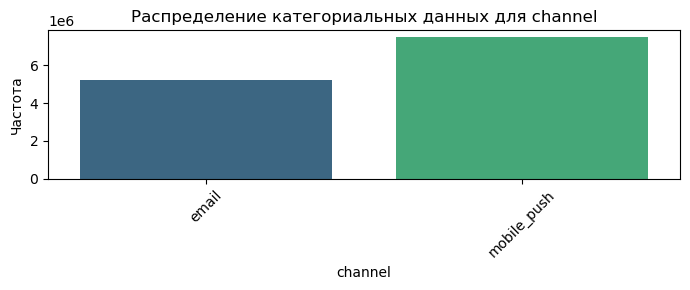

Статистическое описание для channel
channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64




In [269]:
messages_cat_columns = ['event', 'channel']

plot_overlay_bar_charts(df_messages, messages_cat_columns)

 - Рассылок с номерами id 14 тыс было существенно больше, чем других. Возможно проводились глобальные акции
 - Касательно признака event мы видим классическую воронку продаж: с каждым этапом, кол-во дейcтвий меньше. send, open, click, успех в покупку - purchase, неудача - hard_bounce, soft_bounce, unsubscribe, hbq_spam, complain. 
 - Канал рассылки примерно в 2 раза больше, чем push уведомление

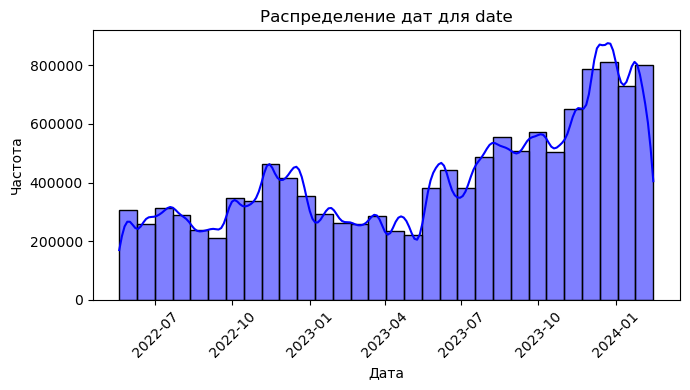

Статистическое описание для date
count                         12691188
mean     2023-06-04 17:27:00.569989632
min                2022-05-19 00:00:00
25%                2022-12-16 00:00:00
50%                2023-07-20 00:00:00
75%                2023-11-21 00:00:00
max                2024-02-15 00:00:00
Name: date, dtype: object




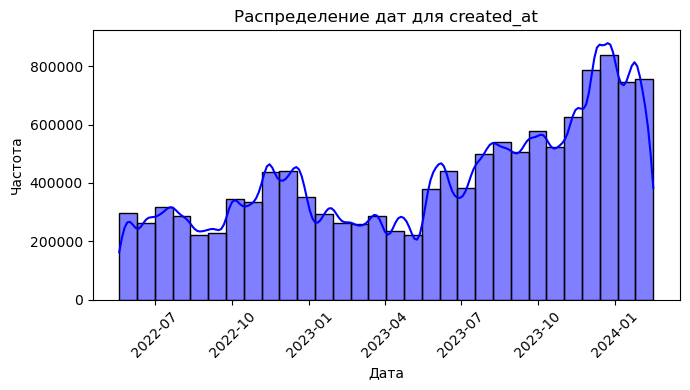

Статистическое описание для created_at
count                         12691188
mean     2023-06-05 04:38:55.658559232
min                2022-05-19 00:14:20
25%                2022-12-16 19:15:55
50%                2023-07-20 11:09:42
75%                2023-11-21 15:58:05
max                2024-02-15 23:58:40
Name: created_at, dtype: object




In [270]:
messages_date_columns =['date', 'created_at'] 
plot_date_distributions(df_messages, messages_date_columns)

 - Кол-во рассылок медленно растет и а 24 году гораздо больше, чем было в 22 и 23, что не скажешь о продажах, максимальные продажи были в 23 году

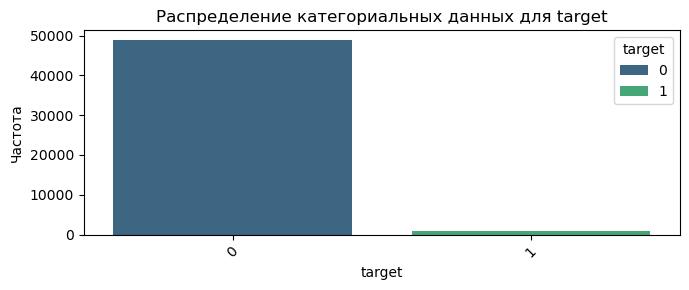

Статистическое описание для target
target
0    48888
1      961
Name: count, dtype: int64




In [271]:
target_cat_columns = ['target']

plot_overlay_bar_charts(df_target, target_cat_columns)

- В таргете видим большо дисбаланас классов. Некупивших намного больше, чем купивших. Но, возможно, это норально

### Добавление новых признаков

#### df_purchases

In [272]:
# Добавим колонки с годом покупки year_purchase и месяцем покупки month_purchase

df_purchases['year_purchase'] = df_purchases['date'].dt.year
df_purchases['month_purchase'] = df_purchases['date'].dt.month


In [273]:
df_purchases.sample(5)

,client_id,quantity,price,category_ids,date,message_id,category_1,category_2,category_3,category_4,year_purchase,month_purchase
105856,1515915625468245266,1,1076.0,"[4, 28, 340, 1312]",2023-04-16,1515915625468245266-11792-643802c7ac885,4,28,340,1312,2023,4
112548,1515915625602183333,1,466.0,"[4, 28, 290, 422]",2023-04-28,1515915625724865712-12218-644b837f80d8d,4,28,290,422,2023,4
183589,1515915625544104824,1,400.0,"[5562, 5630, 5607, 555]",2023-12-21,1515915625544104824-14350-6582a29365bc5,5562,5630,5607,555,2023,12
190863,1515915625587715621,1,1049.0,"[5562, 5630, 5548, 665]",2023-12-30,1515915625587715621-14410-658e6f3ea33cb,5562,5630,5548,665,2023,12
57650,1515915625468252284,1,189.0,"[2, 17, 83, 519]",2022-11-16,1515915625468252284-7845-637335833c775,2,17,83,519,2022,11


In [274]:
# Создадим новый признак кол-во покупок в разные дни quantity_days
unique_purchase_days = df_purchases.groupby('client_id')['date'].nunique().reset_index(name='unique_purchase_days')

unique_purchase_days.sort_values('unique_purchase_days', ascending=False)

,client_id,unique_purchase_days
44817,1515915625853312319,41
13493,1515915625490334876,23
45067,1515915625860624470,17
24648,1515915625554355124,16
31601,1515915625579040539,15
...,...,...
18139,1515915625496641216,1
18140,1515915625496649488,1
18141,1515915625496651674,1
18142,1515915625496653544,1


Регулярные покупки - отличый признак, на этих клиентов мы можем рассчитывать в ближайшее время

In [275]:
# Создадим новый признак дальность последней покупки в днях
# Находим дату последней покупки для каждого client_id
last_purchase_date = df_purchases.groupby('client_id')['date'].max().reset_index()

# Определим дату выгрузки df
last_purchase = df_purchases['date'].max() + pd.Timedelta(days=1)

# Вычислим дальность последней покупки в днях
last_purchase_date['days_since_last_purchase'] = (last_purchase - last_purchase_date['date']).dt.days

#last_purchase_date.drop_column['date']
last_purchase_date.sort_values('days_since_last_purchase', ascending=False)

# удалим колонку date 
last_purchase_date = last_purchase_date.drop(columns=['date'])

last_purchase_date.sort_values('days_since_last_purchase', ascending=False)

,client_id,days_since_last_purchase
41673,1515915625776110064,642
3081,1515915625471138230,642
16622,1515915625491478747,642
40190,1515915625730423268,642
17531,1515915625491869271,642
...,...,...
46373,1515915625912275243,1
14953,1515915625490832103,1
49353,1515915626000416409,1
41946,1515915625780966033,1


Кто- не покупал почти 2 года и вряд ли купит в ближайшее время

In [276]:
# Создадим новый признак период покупок в днях, как дата последней покупки - дата первой покупки

# Нахождение первой и последней даты покупки для каждого client_id
purchase_dates = df_purchases.groupby('client_id')['date'].agg(['min', 'max']).reset_index()

# Вычисление количества дней между первой и последней покупкой
purchase_dates['days_between_first_and_last'] = (purchase_dates['max'] - purchase_dates['min']).dt.days

purchase_dates =  purchase_dates.drop(columns=['min', 'max'])

purchase_dates.sort_values('days_between_first_and_last', ascending=False)

,client_id,days_between_first_and_last
4918,1515915625478751298,636
17169,1515915625491750681,627
7811,1515915625488290703,619
9250,1515915625488916405,617
4381,1515915625475169728,617
...,...,...
18139,1515915625496641216,0
18140,1515915625496649488,0
18141,1515915625496651674,0
18142,1515915625496653544,0


Кто-то продолжает покупать на протяжении всего времени

In [277]:
# Сгруппируем df_purchases  по client_id и объединим его с нашими признаками. Отбросим ненужные признаки: category_ids, date, message_id

df_purchases_grouped = df_purchases.groupby('client_id').agg({
    'quantity': 'sum',
    'price': 'sum',
    'category_1': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'category_2': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'category_3': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'category_4': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'year_purchase': ['min', 'max'],
    'month_purchase': 'count'
    #'month_purchase': lambda x: x.mode().iloc[0] if not x.mode().empty else None
}).reset_index()
                                                            
df_purchases_grouped

client_id quantity    price category_1 category_2 category_3  \
                                sum      sum   <lambda>   <lambda>   <lambda>   
0      1515915625468060902        7   6993.0          4         28        176   
1      1515915625468061003        7  16235.0          4         28        249   
2      1515915625468061099        1    299.0          4         28        290   
3      1515915625468061100        2   2098.0          4         27       1828   
4      1515915625468061170       19  33601.0          4         28        260   
...                    ...      ...      ...        ...        ...        ...   
49844  1515915626010261344        6   8994.0          2         18        212   
49845  1515915626010266132        2   1818.0          4         27        278   
49846  1515915626010439406        2    198.0          4         27        233   
49847  1515915626010443527        1   1999.0          2         18        274   
49848  1515915626010443624        1    999.0          4         28         62   

      category_4 year_purchase       month_purchase  
        <lambda>           min   max          count  
0            420          2022  2022              7  
1            615          2023  2023              7  
2            424          2022  2022              1  
3           5717          2024  2024              2  
4            420          2023  2023             19  
...          ...           ...   ...            ...  
49844        726          2024  2024              6  
49845        470          2024  2024              2  
49846        462          2024  2024              2  
49847        446          2024  2024              1  
49848        656          2024  2024              1  

[49849 rows x 10 columns]

In [278]:
df_purchases_grouped.columns = ['client_id', 'total_quantity', 'total_price', 'pref_cat_1', 'pref_cat_2', 'pref_cat_3', 'pref_cat_4', 'min_year', 'max_year' ,'cnt_month']
df_purchases_grouped

,client_id,total_quantity,total_price,pref_cat_1,pref_cat_2,pref_cat_3,pref_cat_4,min_year,max_year,cnt_month
0,1515915625468060902,7,6993.0,4,28,176,420,2022,2022,7
1,1515915625468061003,7,16235.0,4,28,249,615,2023,2023,7
2,1515915625468061099,1,299.0,4,28,290,424,2022,2022,1
3,1515915625468061100,2,2098.0,4,27,1828,5717,2024,2024,2
4,1515915625468061170,19,33601.0,4,28,260,420,2023,2023,19
...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,6,8994.0,2,18,212,726,2024,2024,6
49845,1515915626010266132,2,1818.0,4,27,278,470,2024,2024,2
49846,1515915626010439406,2,198.0,4,27,233,462,2024,2024,2
49847,1515915626010443527,1,1999.0,2,18,274,446,2024,2024,1


In [279]:
df_purchases_grouped.shape

(49849, 10)

In [280]:
# Объединим с новыми признаками по client_id

df_purchases_grouped = df_purchases_grouped.merge(unique_purchase_days, on='client_id', how='left')
df_purchases_grouped = df_purchases_grouped.merge(last_purchase_date, on='client_id', how='left')
df_purchases_grouped = df_purchases_grouped.merge(purchase_dates, on='client_id', how='left')


In [281]:
df_purchases_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   client_id                    49849 non-null  int64  
 1   total_quantity               49849 non-null  int64  
 2   total_price                  49849 non-null  float64
 3   pref_cat_1                   49848 non-null  object 
 4   pref_cat_2                   49848 non-null  object 
 5   pref_cat_3                   49848 non-null  object 
 6   pref_cat_4                   49742 non-null  object 
 7   min_year                     49849 non-null  int32  
 8   max_year                     49849 non-null  int32  
 9   cnt_month                    49849 non-null  int64  
 10  unique_purchase_days         49849 non-null  int64  
 11  days_since_last_purchase     49849 non-null  int64  
 12  days_between_first_and_last  49849 non-null  int64  
dtypes: float64(1), i

In [282]:
# Заполним пропуски в pref_cat_4 на 0 

df_purchases_grouped['pref_cat_4'] = df_purchases_grouped['pref_cat_4'].fillna(0)

In [283]:
df_purchases_grouped.shape

(49849, 13)

#### df_messages

In [284]:
df_messages.sample(5)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
6239500,13500,1515915625552322347,1515915625552322347-13500-64b15515c766f,send,mobile_push,2023-07-14,2023-07-14 15:20:23
9437849,14137,1515915625503608802,1515915625503608802-14137-655748261de19,send,mobile_push,2023-11-17,2023-11-17 11:24:49
9963594,14249,1515915625499450961,1515915625499450961-14249-65704cee83d64,send,mobile_push,2023-12-06,2023-12-06 10:55:52
6082861,13452,1515915625500265386,1515915625500265386-13452-64a666f1b4995,send,email,2023-07-06,2023-07-06 07:23:26
10520385,14334,1515915625490055208,1515915625490055208-14334-65814d3f1ea53,send,email,2023-12-19,2023-12-19 08:07:40


In [285]:
df_messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [286]:
# Получаем уникальные события
unique_events = df_messages['event'].unique()
unique_channel = df_messages['channel'].unique()

# Создаем дамми-переменные для событий
event_dummies = pd.get_dummies(df_messages['event'])
channel_dummies = pd.get_dummies(df_messages['channel'])

# Объединяем исходный DataFrame с дамми-переменными
df_combined = pd.concat([df_messages[['client_id']], event_dummies, channel_dummies], axis=1)

# Группируем по client_id и суммируем количество каждого события
event_counts = df_combined.groupby('client_id').sum().reset_index()

event_counts

,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,email,mobile_push
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1,177,0
1,1515915625468061003,5,0,0,0,0,5,1,154,0,0,0,165,0
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0,182,94
3,1515915625468061100,1,0,0,1,0,157,1,267,1,0,0,0,428
4,1515915625468061170,16,0,0,0,0,31,3,243,0,0,0,202,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53324,1515915626010183608,0,0,0,0,0,2,0,2,0,0,0,0,4
53325,1515915626010221592,2,0,0,0,0,2,0,2,0,0,0,0,6
53326,1515915626010234726,0,0,0,0,0,0,0,1,0,0,0,0,1
53327,1515915626010261344,1,0,0,0,0,1,0,1,0,0,0,0,3


In [287]:
event_counts.sample(5)

,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,email,mobile_push
40638,1515915625669332739,8,0,0,0,0,23,1,214,0,0,0,0,246
12203,1515915625489260513,4,0,0,0,0,163,2,282,0,0,0,156,295
27804,1515915625553651695,0,0,0,0,0,0,0,157,0,0,0,0,157
49789,1515915625963656753,9,0,0,0,0,9,1,79,0,0,0,98,0
47481,1515915625860460184,10,0,0,0,0,0,2,156,0,0,0,0,168


In [288]:
df_messages['event'].value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

In [289]:
# Удалим ненужные колонки
event_counts = event_counts.drop(columns=['hard_bounce', 'soft_bounce', 'hbq_spam', 'unsubscribe'])



In [290]:
# Изменим порядок колонок для удобства

event_counts = event_counts[['client_id', 'send', 'open', 'click', 'purchase','subscribe', 'email', 'mobile_push']]

event_counts

,client_id,send,open,click,purchase,subscribe,email,mobile_push
0,1515915625468060902,126,35,10,5,0,177,0
1,1515915625468061003,154,5,5,1,0,165,0
2,1515915625468061099,215,51,8,0,0,182,94
3,1515915625468061100,267,157,1,1,0,0,428
4,1515915625468061170,243,31,16,3,0,202,91
...,...,...,...,...,...,...,...,...
53324,1515915626010183608,2,2,0,0,0,0,4
53325,1515915626010221592,2,2,2,0,0,0,6
53326,1515915626010234726,1,0,0,0,0,0,1
53327,1515915626010261344,1,1,1,0,0,0,3


#### Объединяем в единый датафрейм

In [291]:
df_total = df_purchases_grouped.merge(event_counts, on='client_id', how='left')

df_total.info()
df_total.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   client_id                    49849 non-null  int64  
 1   total_quantity               49849 non-null  int64  
 2   total_price                  49849 non-null  float64
 3   pref_cat_1                   49848 non-null  object 
 4   pref_cat_2                   49848 non-null  object 
 5   pref_cat_3                   49848 non-null  object 
 6   pref_cat_4                   49849 non-null  object 
 7   min_year                     49849 non-null  int32  
 8   max_year                     49849 non-null  int32  
 9   cnt_month                    49849 non-null  int64  
 10  unique_purchase_days         49849 non-null  int64  
 11  days_since_last_purchase     49849 non-null  int64  
 12  days_between_first_and_last  49849 non-null  int64  
 13  send            

(49849, 20)

In [292]:
# Пропуски заменим нулями

df_total = df_total.fillna(0)

df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   client_id                    49849 non-null  int64  
 1   total_quantity               49849 non-null  int64  
 2   total_price                  49849 non-null  float64
 3   pref_cat_1                   49849 non-null  object 
 4   pref_cat_2                   49849 non-null  object 
 5   pref_cat_3                   49849 non-null  object 
 6   pref_cat_4                   49849 non-null  object 
 7   min_year                     49849 non-null  int32  
 8   max_year                     49849 non-null  int32  
 9   cnt_month                    49849 non-null  int64  
 10  unique_purchase_days         49849 non-null  int64  
 11  days_since_last_purchase     49849 non-null  int64  
 12  days_between_first_and_last  49849 non-null  int64  
 13  send            

In [293]:
# Также объединим с df_target
df_total = df_total.merge(df_target, on='client_id', how='left')

In [294]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   client_id                    49849 non-null  int64  
 1   total_quantity               49849 non-null  int64  
 2   total_price                  49849 non-null  float64
 3   pref_cat_1                   49849 non-null  object 
 4   pref_cat_2                   49849 non-null  object 
 5   pref_cat_3                   49849 non-null  object 
 6   pref_cat_4                   49849 non-null  object 
 7   min_year                     49849 non-null  int32  
 8   max_year                     49849 non-null  int32  
 9   cnt_month                    49849 non-null  int64  
 10  unique_purchase_days         49849 non-null  int64  
 11  days_since_last_purchase     49849 non-null  int64  
 12  days_between_first_and_last  49849 non-null  int64  
 13  send            

In [295]:
# Проверим на дубликаты

df_total.duplicated().sum()


0

 - Мы создали много новых признаков, которые могут влиять на обучение модели: cnt_month, unique_purchase_days, days_since_last_purchase, days_between_first_and_last
 - Также объединили все в один итоговый датафрейм. Переходим к корреляции данных


### Корреляция данных 

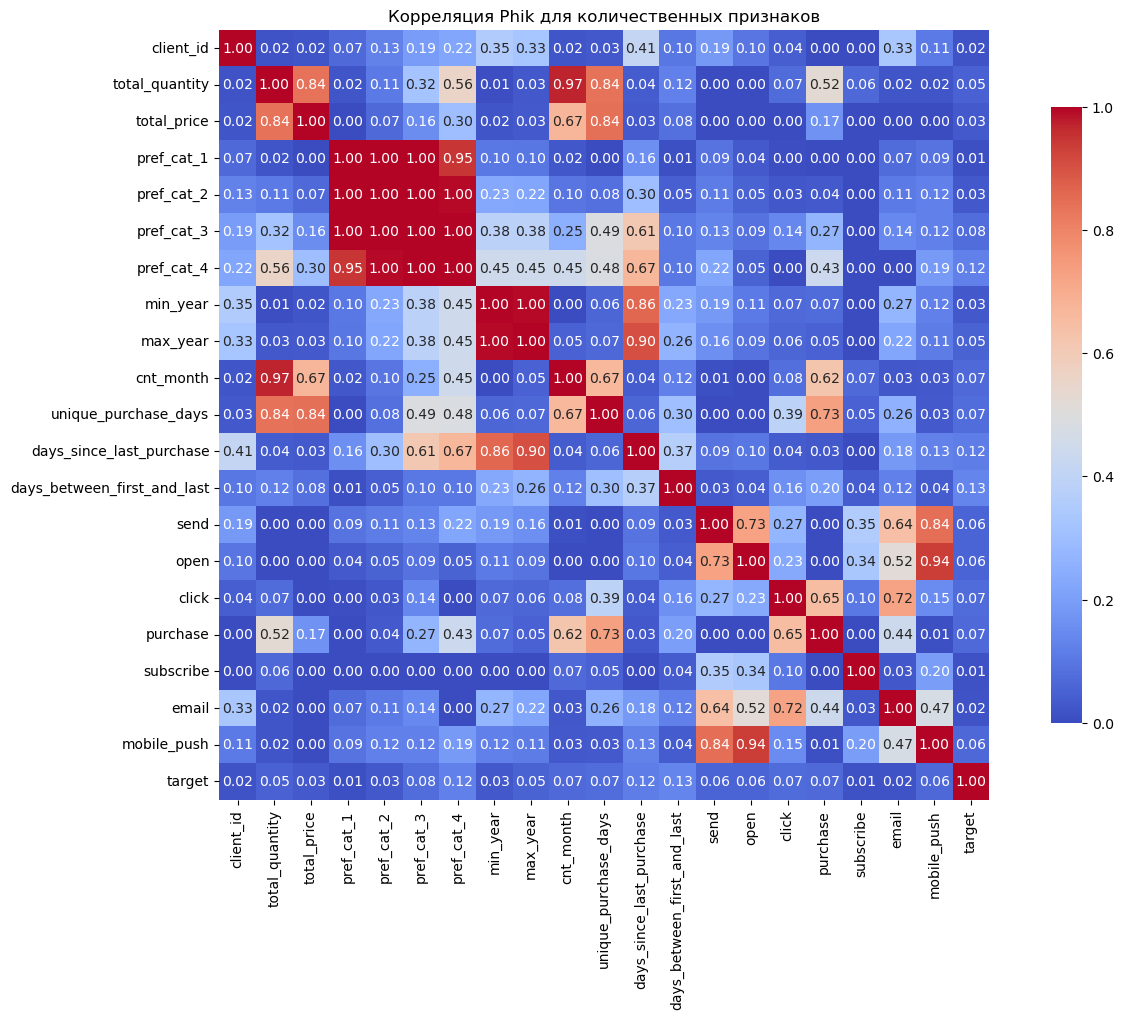

In [296]:
# Задаем список количественных признаков
interval_cols = df_total.select_dtypes(include=['number'])

# Вычисляем корреляцию phik
phik_corr = df_total.phik_matrix(interval_cols = interval_cols)


# Отображаем с помощью sns.heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Корреляция Phik для количественных признаков')
plt.show()

# phik_corr.phik_matrix(interval_cols = interval_cols)

- Обнаружена мультиколлинеарность между pref_cat_1, pref_cat_2, pref_cat_3, pref_cat_4. Оставим только pref_cat1
- Мультиколлинеарность между total_quantity, cnt_month. Оставим только total_quantity
- Мультиколлинеарность между min_year, max_year. Удалим оба признака



In [297]:
#Создадим список колонок для удаления
columns_to_drop = ['client_id', 'pref_cat_2', 'pref_cat_3', 'pref_cat_4', 'cnt_month', 'min_year','max_year']

In [298]:
df_final = df_total.drop(columns_to_drop, axis=1)

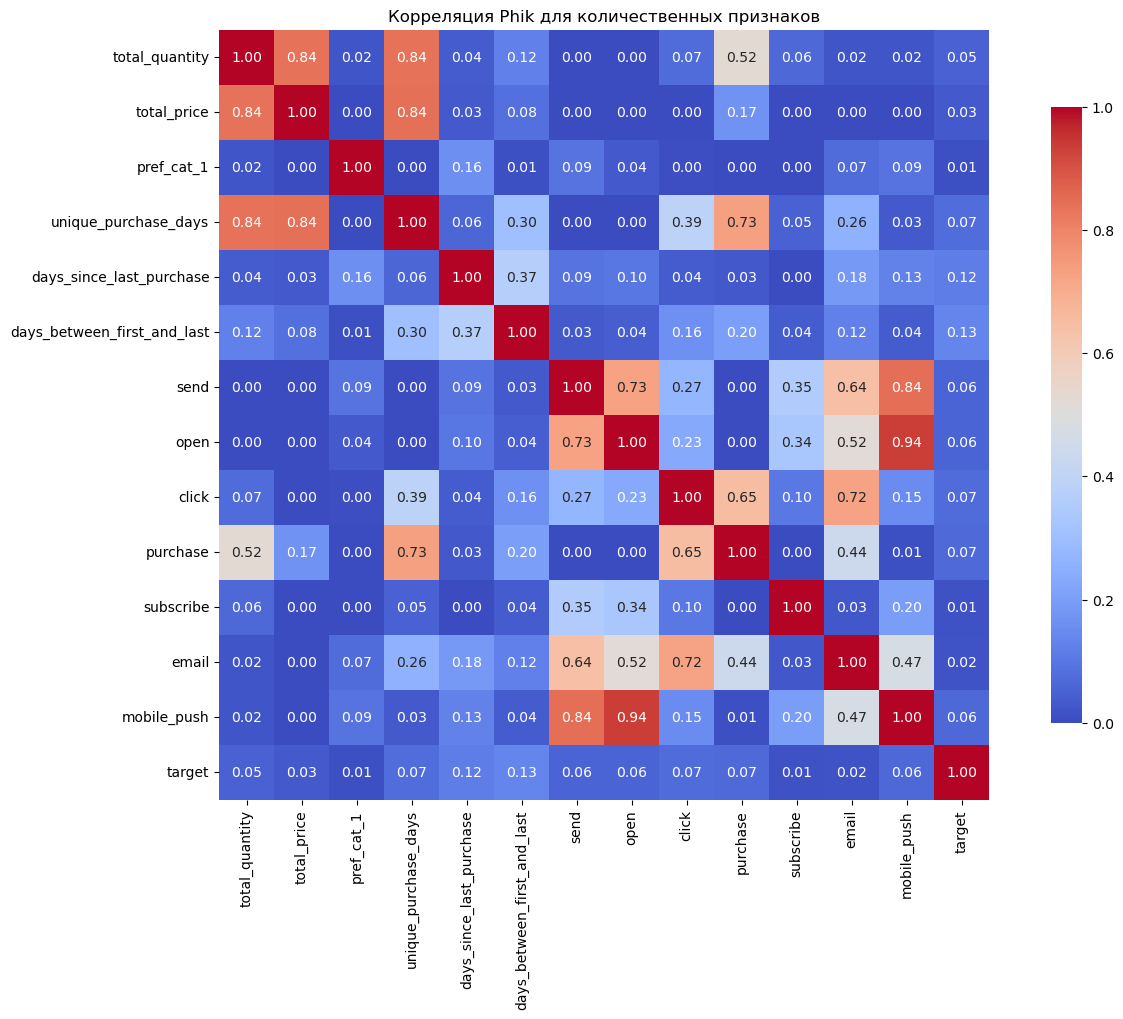

In [299]:
# Задаем список количественных признаков
interval_cols = df_final.select_dtypes(include=['number'])

# Вычисляем корреляцию phik
phik_corr = df_final.phik_matrix(interval_cols = interval_cols)


# Отображаем с помощью sns.heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Корреляция Phik для количественных признаков')
plt.show()


- Осталась только высокая корреляция между mobile_push и open. Оставим, как есть

### Пайплайн

In [300]:
# Проверим на дубликаты df_train_final

df_final.duplicated().sum()

344

In [301]:
# Удалим дубликаты

df_final = df_final.drop_duplicates()

In [302]:
# Проверим на наличие пропусков
df_final.isnull().sum()

total_quantity                 0
total_price                    0
pref_cat_1                     0
unique_purchase_days           0
days_since_last_purchase       0
days_between_first_and_last    0
send                           0
open                           0
click                          0
purchase                       0
subscribe                      0
email                          0
mobile_push                    0
target                         0
dtype: int64

In [303]:
# Разделение X и y
X = df_final.drop('target', axis=1)
y = df_final['target']

# Разделение на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [304]:
print('Тренировочные данные', X_train.shape, y_train.shape)
print('Валидационные данные', X_test.shape, y_test.shape)

Тренировочные данные (37128, 13) (37128,)
Валидационные данные (12377, 13) (12377,)


In [305]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49505 entries, 0 to 49848
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   total_quantity               49505 non-null  int64  
 1   total_price                  49505 non-null  float64
 2   pref_cat_1                   49505 non-null  object 
 3   unique_purchase_days         49505 non-null  int64  
 4   days_since_last_purchase     49505 non-null  int64  
 5   days_between_first_and_last  49505 non-null  int64  
 6   send                         49505 non-null  float64
 7   open                         49505 non-null  float64
 8   click                        49505 non-null  float64
 9   purchase                     49505 non-null  float64
 10  subscribe                    49505 non-null  float64
 11  email                        49505 non-null  float64
 12  mobile_push                  49505 non-null  float64
 13  target               

In [306]:
df_final['pref_cat_1'].unique()

array(['4', '5562', '6060', '2', '5963', 0, '3', '1'], dtype=object)

In [307]:
df_final['pref_cat_1'] = df_final['pref_cat_1'].astype('float64')

In [308]:
# Определяем пайплайн для кодирования категориальных  и количественных признаков

num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Перечисляем столбцы
num_cols = X_train.select_dtypes(include=['number']).columns

# Создаем ColumnTransformer
data_preprocessor = ColumnTransformer(
    transformers=[
    ('num', num_pipe, num_cols)
    ],
    remainder='passthrough'
)

In [309]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE)) 
    ]
)

In [310]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [CatBoostClassifier(random_seed=RANDOM_STATE)],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
     'models__iterations': [100, 200],
     'models__depth': [3, 5],
     'models__learning_rate': [0.01, 0.1],

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [XGBClassifier(random_state=RANDOM_STATE)],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
     'models__n_estimators': [50, 100, 150],
     'models__max_depth': [3, 5, 7],
     'models__learning_rate': [0.01, 0.1],
    },
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__max_depth': [3, 5],
        'models__learning_rate': [0.05, 0.1],
        'models__n_estimators': [50, 100]         
    }
]

In [311]:
grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    error_score='raise',
    verbose=2
)

In [312]:
#обучение модели на тренировочной выборке
grid.fit(X_train, y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
0:	learn: 0.5201652	total: 24.6ms	remaining: 4.89s
1:	learn: 0.3971233	total: 34.5ms	remaining: 3.42s
2:	learn: 0.3094114	total: 42.6ms	remaining: 2.8s
3:	learn: 0.2496093	total: 52ms	remaining: 2.55s
4:	learn: 0.2056381	total: 62.9ms	remaining: 2.45s
5:	learn: 0.1746001	total: 71.5ms	remaining: 2.31s
6:	learn: 0.1537401	total: 80.4ms	remaining: 2.22s
7:	learn: 0.1375606	total: 89.2ms	remaining: 2.14s
8:	learn: 0.1264539	total: 97ms	remaining: 2.06s
9:	learn: 0.1179206	total: 107ms	remaining: 2.03s
10:	learn: 0.1118108	total: 117ms	remaining: 2s
11:	learn: 0.1070309	total: 127ms	remaining: 1.98s
12:	learn: 0.1030275	total: 135ms	remaining: 1.95s
13:	learn: 0.0998524	total: 143ms	remaining: 1.9s
14:	learn: 0.0977644	total: 152ms	remaining: 1.87s
15:	learn: 0.0958275	total: 160ms	remaining: 1.84s
16:	learn: 0.0943917	total: 170ms	remaining: 1.83s
17:	learn: 0.0931938	total: 179ms	remaining: 1.81s
18:	learn: 0.0922859	total: 1

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['total_quantity', 'total_price', 'unique_purchase_days',
       'days_since_last_purchase', 'days_between_first_and_last', 'send',
       'open', '...
                          'models__max_depth': [3, 5, 7],
                          'models__n_estimators': [50, 100, 150],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LGBMClassifier(random_state=42)],
                          'models__learning_rate': [0.05, 0.1],
                          'models__max_depth': [3, 5],
                          'models__n_estimators': [50, 100],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc', verbose=2)

In [313]:
print('Метрика Roc-auc для лучшей модели:\n', grid.best_score_)
print('Лучшая модель и ее параметры:\n', grid.best_params_)

Метрика Roc-auc для лучшей модели:
 0.7398132099432331
Лучшая модель и ее параметры:
 {'models': <catboost.core.CatBoostClassifier object at 0x000001460F6F15E0>, 'models__depth': 3, 'models__iterations': 200, 'models__learning_rate': 0.1, 'preprocessor__num': 'passthrough'}


### Применение модели к тестовой выборке

In [314]:
# Применяем лучшую модель на тестовой выборке

y_pred =  grid.best_estimator_.predict(X_test)
proba = grid.best_estimator_.predict_proba(X_test)

In [315]:
# считаем и выводим roc_auc
roc_auc = roc_auc_score(y_test, proba[:,1])
print('ROC-AUC =', round(roc_auc,4))

ROC-AUC = 0.7547


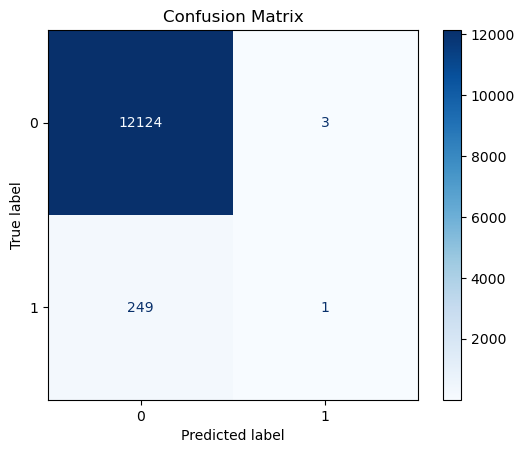

In [316]:
# 1. Создание матрицы ошибок
cm = confusion_matrix(y_test, y_pred)

# 2. Визуализация матрицы ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Исходя из полученных результатов, можно сделать следующие выводы:
 - модель показала достаточно высокую метрику Roc-auc - 0.75
 - при этом она слабо определяет реальных покупателей из 249 покупателей, модель смогла определить только 1

### Анализ важности признаков Shap

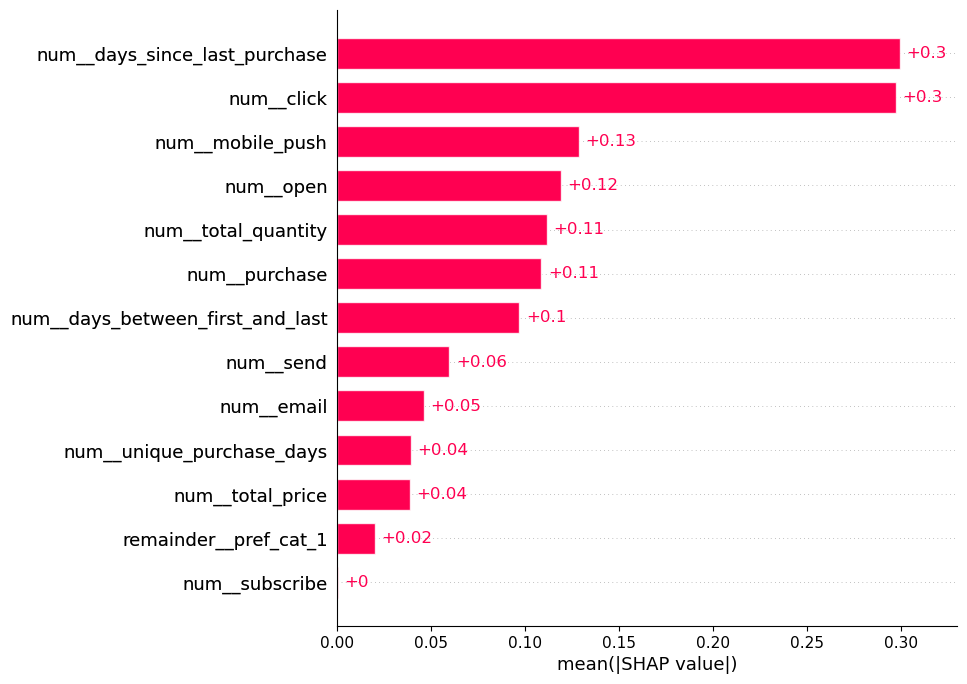

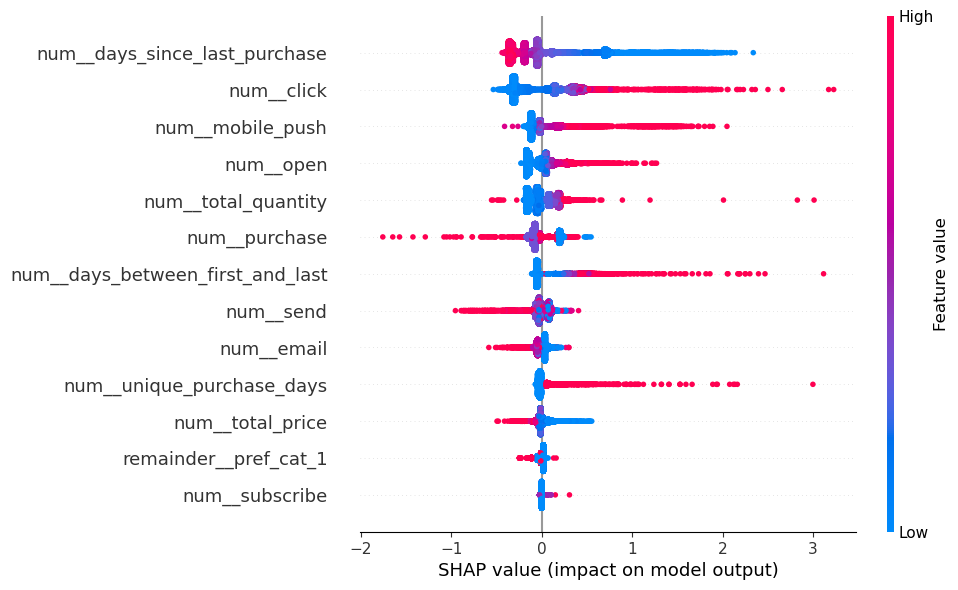

In [317]:
#Найдем важные признаки с помощью метода SHAP

X_1 = grid.best_estimator_['preprocessor'].transform(X_train)

explainer = shap.TreeExplainer(grid.best_estimator_['models'])

# Получение имен признаков из обученного предварительного процессора
feature_names = grid.best_estimator_['preprocessor'].get_feature_names_out()

# Преобразование тренировочного набора в DataFrame для анализа SHAP
X_1_df = pd.DataFrame(X_1, columns=feature_names)

# Вычисление значений SHAP для тренировочного набора
shap_values = explainer(X_1_df)


# Отображение результатов с использованием визуализаций SHAP
shap.plots.bar(shap_values, max_display=30)
shap.plots.beeswarm(shap_values, max_display=15)

### Выводы

Целью проекта было построить модель машинного обучения для предсказания покупки: купит или нет.

На этапе изучения данных 3 датафреймов было обнуружено : 
 - уникальный пользоваталей в df_purchases и в df_target - 49849
 - уникальный пользоваталей в df_messages - 53329

На этапе обработки данных были выполнены следующие действия:
 - из category_ids вывели 4 новые категории
 - заменили пропуски в них на 0
 - добавили столбцы с годом покупки year_purchase и месяцем покупки month_purchase
 - Рассылок с номерами id 14 тыс было существенно больше, чем других. Возможно проводились глобальные акции
 - Касательно признака event мы видим классическую воронку продаж: с каждым этапом, кол-во дейcтвий меньше. send, open, click, успех в покупку - purchase, неудача - hard_bounce, soft_bounce, unsubscribe, hbq_spam, complain. 
 - Канал рассылки примерно в 2 раза больше, чем push уведомление
 - Кол-во рассылок медленно растет и а 24 году гораздо больше, чем было в 22 и 23, что не скажешь о продажах, максимальные продажи были в 23 году

На этапе исследования и корелляционного анализа данных данных были выполнены следующие действия:
 - Обнаружена мультиколлинеарность между pref_cat_1, pref_cat_2, pref_cat_3, pref_cat_4. Оставили только pref_cat1
 - Мультиколлинеарность между total_quantity, cnt_month. Оставили только total_quantity
 - Мультиколлинеарность между min_year, max_year. Удалили оба признака
 - Осталась только высокая корреляция между mobile_push и open

На этапе построения модели были выполнены следующие действия:
- настроили пайплайн с помощью GridSearchCV и обучили несколько моделей: LogisticRegression, DecisionTreeClassifier, CatBoostClassifier, LogisticRegression, XGBClassifier
- лучший результат показала модель CatBoost на трейне метрика Roc-auc 0.7398, на тесте  метрика Roc-auc 0.7547

Анализ признаков показал, что на таргет сильно влияет: num__days_since_last_purchase, num__click, num__mobile_push. 

Значит пользователи хорошо реагируют на пуш уведомления из приложения. И чем чаще пользователь покупает, и чем меньше дней с момента последней покупки, тем больше шансов, что он купит в ближайшее время. Таким пользователям нужно чаще рассылать уведомлния, чтобы они не забывали про маркетплейс    